# 

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
import numpy as np

In [3]:
import pandas as pd
if IN_COLAB:
    file = google.colab.files.upload('Загрузите файл данных с солнечной электростанции')
    data = pd.read_csv(file)
else:
    data = pd.read_csv('~/Study/SolarPower/AutoLSTM/GermanSolarFarm/data/pv_01.csv', delimiter=';')
data = data.drop('Unnamed: 51', axis=1)
unused_features = [
    "time_idx", "sunposition_extraTerr", "sunposition_solarHeight", "clearsky_diffuse",
    "clearsky_direct", "clearsky_global", "clearsky_diffuse_agg",
    "clearsky_direct_agg", "clearsky_global_agg", "Albedo", "WindComponentUat0",
    "WindComponentVat0", "WindComponentUat100", "WindComponentVat100",
    "PotentialVorticityAt1000", "PotentialVorticityAt950",
    "RelativeHumidityAt1000", "RelativeHumidityAt950", "SnowDensityAt0",
    "SnowfallPlusStratiformSurfaceAt0", "SolarRadiationGlobalAt0",
    "SolarRadiationDirectAt0", "LowerWindDirectionMath", "UpperWindSpeed",
    "UpperWindDirection", "UpperWindDirectionMath", "UpperWindDirectionCos",
    "UpperWindDirectionSin", "power_normed"
]
for feature in unused_features:
    data = data.drop(feature, axis=1)
radiation = data.pop('SolarRadiationDiffuseAt0')

print('Dataset size: ', data.shape)
print(data.columns)


Dataset size:  (6217, 21)
Index(['hour_of_day', 'hour_of_day_cos', 'hour_of_day_sin', 'month_of_year',
       'month_of_year_cos', 'month_of_year_sin', 'season_of_year',
       'season_of_year_cos', 'season_of_year_sin', 'sunposition_thetaZ',
       'sunposition_solarAzimuth', 'DewpointTemperatureAt0', 'TemperatureAt0',
       'RelativeHumidityAt0', 'SnowDepthAt0', 'SurfacePressureAt0',
       'TotalCloudCoverAt0', 'LowerWindSpeed', 'LowerWindDirection',
       'LowerWindDirectionCos', 'LowerWindDirectionSin'],
      dtype='object')


In [4]:
from keras import models, optimizers
from keras.layers import Input, Dense
from keras.layers import InputLayer

input_dim = data.shape[1]

autoencoder = models.Sequential()

autoencoder.add(InputLayer(input_shape=(input_dim,)))  # input_dim - размер входных данных
autoencoder.add(Dense(8))  # input_dim - размер выходных данных
autoencoder.add(Dense(input_dim))  # input_dim - размер выходных данных

opt = optimizers.Adam(learning_rate=0.00001)
autoencoder.compile(optimizer=opt, loss='mean_squared_error')

features = np.array(data)

autoencoder.fit(features, features, epochs=500, batch_size=100, shuffle=True, verbose=1)

2023-12-07 08:45:27.624487: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 08:45:27.625983: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-07 08:45:27.650245: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 08:45:27.650273: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 08:45:27.650291: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

Epoch 1/500
63/63 [==============================] - 0s 846us/step - loss: 0.6391
Epoch 2/500
63/63 [==============================] - 0s 780us/step - loss: 0.6297
Epoch 3/500
63/63 [==============================] - 0s 733us/step - loss: 0.6206
Epoch 4/500
63/63 [==============================] - 0s 897us/step - loss: 0.6117
Epoch 5/500
63/63 [==============================] - 0s 1ms/step - loss: 0.6030
Epoch 6/500
63/63 [==============================] - 0s 1ms/step - loss: 0.5946
Epoch 7/500
63/63 [==============================] - 0s 922us/step - loss: 0.5865
Epoch 8/500
63/63 [==============================] - 0s 1ms/step - loss: 0.5785
Epoch 9/500
63/63 [==============================] - 0s 1ms/step - loss: 0.5708
Epoch 10/500
63/63 [==============================] - 0s 669us/step - loss: 0.5633
Epoch 11/500
63/63 [==============================] - 0s 700us/step - loss: 0.5560
Epoch 12/500
63/63 [==============================] - 0s 963us/step - loss: 0.5489
Epoch 13/500
63/63 [=

In [5]:
autoencoder.evaluate(features)
prediction = autoencoder.predict(np.reshape(features[0], [1, input_dim]))
print(prediction)
print(features)

1/1 [==============================] - 0s 40ms/step
[[ 0.05653612  0.9576529   0.4875614   0.7011737  -0.09382738  0.21875626
   0.9800992   0.02555763  0.16736372  0.9953777   0.22214082  0.46990752
   0.28569114  0.9983458   0.0719826   0.5426893   0.6783484   0.33051616
   0.4376487   0.81294346  0.81489503]]
[[0.         1.         0.         ... 0.5586334  0.68174033 0.96580086]
 [0.14285714 0.95782364 0.39933202 ... 0.53150055 0.60019229 0.98985865]
 [0.28571429 0.83827803 0.73254369 ... 0.62344413 0.85116678 0.85592401]
 ...
 [0.85714286 0.09537131 0.63256259 ... 0.58091709 0.74488471 0.935926  ]
 [1.         0.         0.2704272  ... 0.59305925 0.77735479 0.91602201]
 [0.         1.         0.         ... 0.54237407 0.63335547 0.98188828]]


In [6]:
autoencoder.pop()
autoencoder.compile()
autoencoder.summary()
autoencoder.predict(features)[0]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 176       
                                                                 
Total params: 176 (704.00 Byte)
Trainable params: 176 (704.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
195/195 [==============================] - 0s 863us/step


array([ 1.6230541 , -0.49519822, -0.04747859, -0.5229582 ,  0.5035658 ,
       -1.100249  ,  0.48133463, -0.05299725], dtype=float32)

In [7]:
features = autoencoder.predict(features)

195/195 [==============================] - 0s 466us/step


In [8]:
features.shape

(6217, 8)

In [9]:
def prepareData(features, radiation, history_size, forecast_lenth):
    x = []
    y = []
    for i in range(history_size, len(features) - forecast_lenth):
        x.append(features[i - history_size : i])
        y.append(radiation[i : i + forecast_lenth])
    return np.array(x), np.array(y)

In [10]:
from sklearn.model_selection import train_test_split

history_interval = 24 # 3 days
forecast_lenth = history_interval

x, y = prepareData(features, radiation, history_interval, forecast_lenth)
test_idx = int(0.8 * len(x))

x_test = x[test_idx:]
y_test = y[test_idx:]

x_train, x_val, y_train, y_val = train_test_split(x[:test_idx], y[:test_idx], test_size=0.1, random_state=20, shuffle=False)

In [11]:
import tensorflow as tf
from keras import layers
from keras import models
from keras import metrics

model = models.Sequential()
model.add(layers.LSTM(128, activation='tanh', input_shape=(history_interval, 8), return_sequences=True))
model.add(layers.LSTM(64, activation='tanh', return_sequences=True))
model.add(layers.LSTM(32, activation='tanh', return_sequences=True))
model.add(layers.LSTM(24, activation='relu'))
model.add(layers.Dense(forecast_lenth))
model.compile(loss='mse', optimizer='adam', metrics=[metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           70144     
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 24, 32)            12416     
                                                                 
 lstm_3 (LSTM)               (None, 24)                5472      
                                                                 
 dense_2 (Dense)             (None, 24)                600       
                                                                 
Total params: 138040 (539.22 KB)
Trainable params: 138040 (539.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
np.shape(x_train)

(4441, 24, 8)

In [13]:
np.shape(y_train)

(4441, 24)

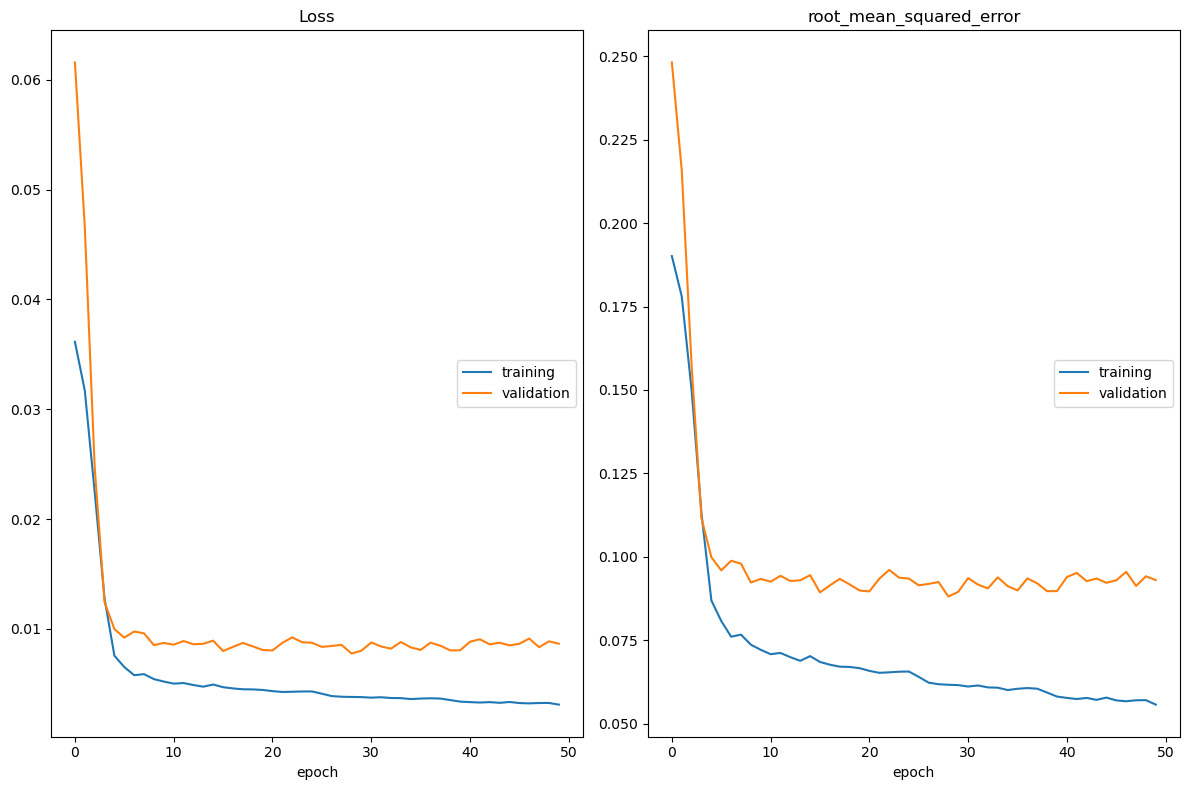

Loss
	training         	 (min:    0.003, max:    0.036, cur:    0.003)
	validation       	 (min:    0.008, max:    0.062, cur:    0.009)
root_mean_squared_error
	training         	 (min:    0.056, max:    0.190, cur:    0.056)
	validation       	 (min:    0.088, max:    0.248, cur:    0.093)
139/139 [==============================] - 6s 41ms/step - loss: 0.0031 - root_mean_squared_error: 0.0557 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0930 - lr: 1.2500e-04


In [14]:
from livelossplot import PlotLossesKeras

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-8)

model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[PlotLossesKeras(), reduce_lr])

In [15]:
results = model.evaluate(x_test, y_test, batch_size=128)

10/10 [==============================] - 0s 40ms/step - loss: 0.0037 - root_mean_squared_error: 0.0605


In [23]:
model.history.history

{}

In [18]:
import matplotlib.pyplot as plt

# Get the training history
history = model.history.history

# Plot the training and validation loss over time
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy over time
plt.plot(history['mae'])
plt.plot(history['val_mae'])
plt.title('Model mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

KeyError: 'loss'